In [1]:
import os
os.chdir('..')

In [2]:
import pysindy as ps
import numpy as np
import xarray as xr
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import root_mean_squared_error

import Yukawa_SINDy as ys
import cross_validation as cv

# import scaling constant from working directory and declare as global variable
with open('scaling_const.float','rb') as f:
    SCALING_CONST = pkl.load(f)

from importlib import reload
from copy import copy

In [3]:
reload(cv)
reload(ys)

<module 'Yukawa_SINDy' from '/Users/zbh0005/Library/CloudStorage/OneDrive-AuburnUniversity/Documents/Code/yukawa-sindy/Yukawa_SINDy.py'>

# Random effects of weak SINDy

Weak SINDy chooses a random sampling of subdomains every time such a model is fit. Here, we will investigate how the number of those subdomains affects the quality of the output by looking at the predictive error and the "true error", or "coefficient error". The predictive error is simply how well the SINDy prediction of the derivative of the data does compared to the calculated error from the Finite Difference method. The coefficient error is the rmse difference between the true coefficient matrix and the learned SINDy coefficient matrix. This gives us an idea of how well SINDy was able to identify the correct model form noisy data.

Let's investigate how the number of subdomains parameter `K` affects the SINDy fitting. I don't perceive that it will change the way that the predictive error is related to the true error, but let's try it for 4 different values of `K`. This will all be with one value of the threshold and one noise level. We found that for a relatively high value of noise, `noise_level = 0.1`, a threshold value of 0.4 often finds the correct model.

In [4]:
threshold = 0.4
noise_level = 0.1

In [5]:
# generate data
sim_list = ys.generate_training_data(mu_x0s=0.5, noise_level=noise_level, scaled=True)

t_data = sim_list[0].t
x_train_list = [sim.x for sim in sim_list[0:150]]
x_train = np.array(x_train_list)
x_test = [sim.x for sim in sim_list[150:200]]

## `K = 100`

This is the default value of K.

In [6]:
# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
K=100
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

,optimizer,STLSQ(threshold=0.4)
,feature_library,<pysindy.feat...t 0x32e318440>
,differentiation_method,FiniteDifference(axis=-2)
,feature_names,"['x0', 'x1']"
,t_default,1
,discrete_time,False
,threshold,0.4
,alpha,0.05
,max_iter,20
,ridge_kw,None
,normalize_columns,False


Now, we use the func `kfold_training` to generate a list of 10 fitted SINDy objects using the weak formulation with a different random sampling of subdomains for the numerical integration. This will give us a list of models and their "predictive error" which is the error generated by the learned SINDy model for the test data during the k-fold validation process.

In [7]:
# need to modify function call, the steps in the cells below have been added to the cv.kfold_training function.
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

TypeError: kfold_training() missing 1 required positional argument: 'true_coefficients'

We can now calculate the error between the learned coefficients of SINDy and the correct coefficient matrix `correct_coefs`, which has the form

$
\begin{pmatrix}
    0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & A & 0 & A & 0 & 0 & 0 & 0 & 0
\end{pmatrix}
$

Where $A$ is the scaling constant, loaded in above, which has the value:

In [ ]:
SCALING_CONST # A

We can now calculate the rmse of the learned coefficient matrices and the correct coefficient matrix, represented as `rmse_true` in the code.

In [ ]:
correct_coefs = np.array(
    [[0, 1] + 8*[0],
     [0, 0, SCALING_CONST, 0, SCALING_CONST] + 5*[0]
    ]
)

In [ ]:
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))


NameError: name 'all_models' is not defined

Now, we can take a look at all the individual models separately, along with their predictive error `rmse_predictive` and error of the coefficient matrix with the true coefficients `rmse_true`:

In [ ]:
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

For ease of reading, here are the models with the lowest predictive rmse and the one which has coefficients which are closest to the true ones:

In [ ]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

Next, we can look at the true coefficient error plotted against the predictive error and see that they are loosely *negatively* correlated:

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

Now, we can look at a Pareto plot of the predictive errors against the number of terms, or complexities, of the models

In [ ]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")

## `K = 300`

In [ ]:
# set K
K=300

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

In [ ]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

In [ ]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")


## `K = 500`

In [ ]:
# set K
K=500

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_coef_dev, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model,
    correct_coefs
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"coef deviation: {all_coef_dev[i]:.4f}")
    print(60*'-' + '\n')

Model 0
(x0)' = 1.000 x1 + -0.852 exp(-x0) / x0^2 + 0.664 exp(-x0) / x0^3
(x1)' = 4.517 exp(-x0) / x0 + 4.277 exp(-x0) / x0^2
pred rmse: 0.0141
coef deviation: 1.8116
------------------------------------------------------------

Model 1
(x0)' = 0.998 x1
(x1)' = 4.464 exp(-x0) / x0 + 4.352 exp(-x0) / x0^2
pred rmse: 0.0151
coef deviation: 0.2769
------------------------------------------------------------

Model 2
(x0)' = 0.999 x1
(x1)' = 1.746 exp(-x0) / x0 + 10.627 exp(-x0) / x0^2 + -3.762 exp(-x0) / x0^3 + 0.376 exp(-x0) / x0^4
pred rmse: 0.0137
coef deviation: 13.0199
------------------------------------------------------------

Model 3
(x0)' = 1.000 x1
(x1)' = 5.826 exp(-x0) / x0 + 2.871 exp(-x0) / x0^2
pred rmse: 0.0141
coef deviation: 2.9548
------------------------------------------------------------

Model 4
(x0)' = 0.999 x1
(x1)' = 5.450 exp(-x0) / x0 + 3.235 exp(-x0) / x0^2
pred rmse: 0.0146
coef deviation: 2.2152
------------------------------------------------------------



In [ ]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_coef_dev[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_coef_dev.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_coef_dev.argmin()]}")
print(f"True coef rmse: {all_coef_dev.min()}")
all_models[all_rmse_true.argmin()].print()

Best prediction:
Model 2
Predictive rmse: 0.0137066486945394
True coef rmse: 13.019902441829444
(x0)' = 0.999 x1
(x1)' = 1.746 exp(-x0) / x0 + 10.627 exp(-x0) / x0^2 + -3.762 exp(-x0) / x0^3 + 0.376 exp(-x0) / x0^4
------------------------------------------------------------

Closest to true:
Model 1
Predictive rmse: 0.01512331109511394
True coef rmse: 0.27685765176057975
(x0)' = 0.998 x1
(x1)' = 4.464 exp(-x0) / x0 + 4.352 exp(-x0) / x0^2


In [ ]:
norm_mat = np.array([1, SCALING_CONST]).reshape(2,1).repeat(10, axis=1)
all_models[all_rmse_predictive.argmin()].coefficients()/norm_mat

array([[ 0.        ,  0.9989654 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.38423136,  0.        ,  2.33814585,
         0.        , -0.82780904,  0.        ,  0.08275316,  0.        ]])

In [ ]:
all_models[all_rmse_true.argmin()].coefficients()/norm_mat

array([[0.        , 0.99794431, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.98208905, 0.        , 0.95744764,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

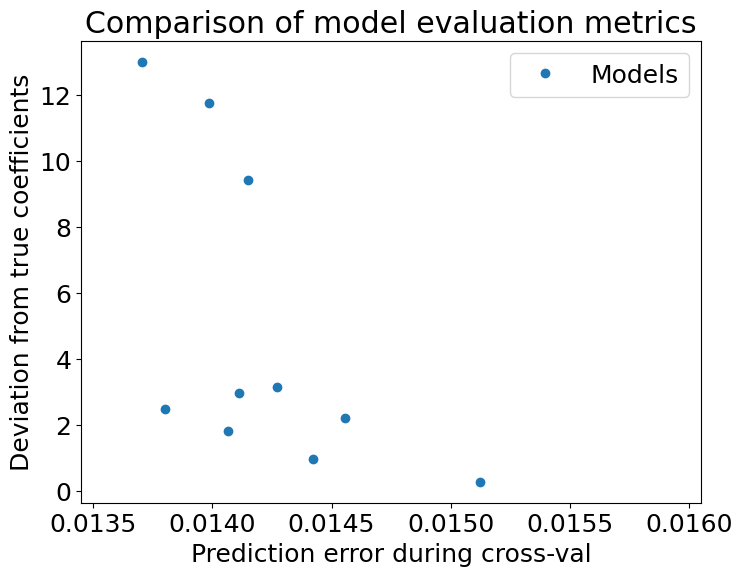

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_coef_dev, 'o', label='Models')
ax.set_title(f"Comparison of model evaluation metrics")
ax.set_xlabel("Prediction error during cross-val")
ax.set_xlim(0.01345, 0.01605)
ax.set_ylabel("Deviation from true coefficients")
ax.legend()

In [ ]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")


## `K = 700`

In [ ]:
# set K
K=700

# generate fitted "test model" SINDy instance to pass into the 
# 'kfold_training' function, this way it gets all the relevant 
# SINDy parameters
weak_library = ys.generate_weak_Yukawa_library(t_data,K=K)
optimizer = ps.STLSQ(threshold=threshold)
test_model = ps.SINDy(
    optimizer = optimizer,
    feature_library = weak_library
)
test_model.fit(x_train_list, t_data, multiple_trajectories=True)

# perform kfold cross-val
all_models, all_rmse_predictive = cv.kfold_training(
    x_train,
    t_data,
    10,
    test_model  
)

# collect coefficients
all_coefs = np.array([model.coefficients() for model in all_models])
all_rmse_true = np.array([])
for coefs in all_coefs:
    rmse_true = root_mean_squared_error(correct_coefs, coefs)
    all_rmse_true = np.hstack((all_rmse_true, rmse_true))

# print all models
for i, model in enumerate(all_models):
    print(f"Model {i}")
    model.print()
    print(f"pred rmse: {all_rmse_predictive[i]:.4f}")
    print(f"true rmse: {all_rmse_true[i]:.4f}")
    print(60*'-' + '\n')

In [ ]:
print("Best prediction:")
print(f"Model {all_rmse_predictive.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive.min()}")
print(f"True coef rmse: {all_rmse_true[all_rmse_predictive.argmin()]}")
all_models[all_rmse_predictive.argmin()].print()
print(60*'-' + '\n')

print("Closest to true:")
print(f"Model {all_rmse_true.argmin()}")
print(f"Predictive rmse: {all_rmse_predictive[all_rmse_true.argmin()]}")
print(f"True coef rmse: {all_rmse_true.min()}")
all_models[all_rmse_true.argmin()].print()

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_rmse_predictive, all_rmse_true, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Predictive error")
ax.set_ylabel("Error with true coefficients")

In [ ]:
# calculate complexities, or number of terms, of all models
all_complexities = np.array([])
for model in all_models:
    complexity = np.count_nonzero(model.coefficients())
    all_complexities = np.hstack((all_complexities, complexity))

fig, ax = plt.subplots()
ax.plot(all_complexities, all_rmse_predictive, 'o')
ax.set_title(f"K = {K}")
ax.set_xlabel("Number of terms")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel("Predictive error")


## All code generating plots

In [ ]:
def calc_errors_and_complexity(K, x_train, t_train, threshold, n_folds):

    global SCALING_CONST

    # unpack x_train and convert to list for 'fit' method
    x_train_list = [traj for traj in x_train]

    weak_library = ys.generate_weak_Yukawa_library(t_data, K=K)
    optimizer = ps.STLSQ(threshold=threshold)
    test_model = ps.SINDy(
        optimizer=optimizer,
        feature_library=weak_library,
        feature_names=['x','v']
    )
    test_model.fit(x_train_list, t_train, multiple_trajectories=True)

    # perform kfold cross-validation
    all_models, all_rmse_predictive = cv.kfold_training(
        x_train,
        t_data,
        n_folds,
        test_model
    )

    # collect coefficients and complexities
    all_coefs = np.array([model.coefficients() for model in all_models])
    all_complexities = np.array([np.count_nonzero(coefs) for coefs in all_coefs])

    # calculate "true error"
    all_rmse_true = np.array([])
    correct_coefs = np.array(
        [[0, 1] + 8*[0],
        [0, 0, SCALING_CONST, 0, SCALING_CONST] + 5*[0]
        ]
    )
    for coefs in all_coefs:
        rmse_true = root_mean_squared_error(correct_coefs, coefs)
        all_rmse_true = np.hstack((all_rmse_true, rmse_true))
    
    return all_complexities, all_rmse_predictive, all_rmse_true
        

def K_param_scan(K_grid: list, n_repeat: int, x_train, t_train, threshold: float=0.4, n_folds: int=10):
    n_models = n_repeat * n_folds
    n_metrics = 3
    all_metrics = np.array([]).reshape((0,n_models,n_metrics))
    for K in K_grid:
        print(K)
        all_metrics_K = np.array([]).reshape((0, n_metrics))
        for n in range(n_repeat):
            print(n)
            metrics_K = calc_errors_and_complexity(K, x_train, t_train, threshold=threshold, n_folds=n_folds)
            # transform to array with dims (10, 3)
            metrics_K = np.array(metrics_K).T
            all_metrics_K = np.concatenate((all_metrics_K, metrics_K), axis=0)
        
        # add dim to all_metrics_K to concatenate
        all_metrics_K.resize((1,) + all_metrics_K.shape)
        print(all_metrics_K, all_metrics_K.shape)
        print(all_metrics, all_metrics.shape)
        all_metrics = np.concatenate((all_metrics, all_metrics_K), axis=0)
    
    # redefine all_metrics to include metadata
    all_metrics = xr.DataArray(
        all_metrics,
        coords = {"K": K_grid, "metric": ["complexity", "predictive error", "coefficient error"]},
        dims = ["K", "model", "metric"]
    )
    
    return all_metrics

In [ ]:
# need to fix, args of kparamscan need to be passed or something
def generate_or_load_data(results_directory='calculations/weak_random_effect_results/', filename='all_metrics.obj'):
    filepath = results_directory + filename
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            all_metrics = pkl.load(f)
    else:
        K_grid = [100, 300, 500, 700]
        n_repeat = 4
        all_metrics = K_param_scan(K_grid, n_repeat, x_train, t_data, threshold)

        # save results
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        with open(filepath, 'wb') as f:
            pkl.dump(all_metrics, f)
    return all_metrics

In [ ]:
all_metrics = generate_or_load_data()

In [ ]:
def plot_model_results(all_metrics: xr.DataArray, plot_num_models: bool, plot_model_pareto: bool, use_color: bool):
    # Check arg types, check if args are valid
    if not (isinstance(plot_num_models, bool) and isinstance(plot_model_pareto, bool) and isinstance(use_color, bool)):
        raise TypeError("plot_num_models, plot_model_pareto, and use_color args are boolean flags")
    if not (plot_num_models or plot_model_pareto): 
        raise ValueError("at least one of the args plot_num_models, plot_model_pareto, or use_color must be `True`")

    # create shared min and max for predictive error 
    # (only needed if plot_num_models and plot_model_pareto)
    all_rmse_pred = all_metrics.sel(metric="predictive error")
    pad = (all_rmse_pred.max() - all_rmse_pred.min()) / 20
    lower_pred = all_rmse_pred.min() - pad
    upper_pred = all_rmse_pred.max() + pad

    # create shared min and max for number of terms
    complexities = all_metrics.sel(metric="complexity").values.astype(int)
    lower_complexity = complexities.min()
    upper_complexity = complexities.max()
    
    # plot
    # set up subplots
    n_rows = 2
    n_cols = 2
    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(12,8), layout='compressed')
    Ks = all_metrics.K.values.reshape((n_rows, n_cols))

    for col in range(n_cols):
        for row in range(n_rows):
            ax = axs[row, col]
            K = Ks[row, col]
            # extract data at particular K
            data = all_metrics.sel(K=K)
            complexities = data.sel(metric="complexity").values.astype(int)
            complexity_counts = np.trim_zeros(np.bincount(complexities))
            rmse_pred = data.sel(metric="predictive error").values
            rmse_true = data.sel(metric="coefficient error").values

            # plot data
            ax.set_title(f"K = {K}")
            
            # complexity ticks only integers
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

            bar_args = (range(lower_complexity, upper_complexity+1), complexity_counts)
            bar_kwargs = {"width": 0.5}
            scatter_args = (complexities, rmse_pred)
            scatter_kwargs = {"s": 96.}
            if plot_model_pareto:
                bar_kwargs.update({"edgecolor": "purple", "color": "None"})
            if use_color:
                scatter_kwargs.update({"c": rmse_true})
            
            # plot which data is desired
            if plot_num_models:
                # histogram of number of models w certain number of terms
                ax.bar(*bar_args, **bar_kwargs)
                if plot_model_pareto:
                    # scatter plot of models and error
                    ax_right = ax.twinx()
                    im = ax_right.scatter(*scatter_args, **scatter_kwargs)
                    # set shared axis for predictive error
                    ax_right.set_ylim(lower_pred, upper_pred)
                    if col==0:
                        ax_right.set_yticks([])
            else:
                im = ax.scatter(*scatter_args, **scatter_kwargs)

    # figure-level labels
    fig.supxlabel("Number of terms")
    right_axis_label_offset = 1.03

    # plot true coefficient error colorbar if using
    if plot_model_pareto and use_color: 
        fig.colorbar(im, ax=axs, label="True coefficient error", pad=0.08, shrink=0.8)
        right_axis_label_offset = 0.86

    if plot_num_models:
        fig.supylabel("Number of models")
        if plot_model_pareto:
            fig.text(x=right_axis_label_offset, y=0.5, s="Predictive error", rotation=90, ha='center', va='center')
    else:
        fig.supylabel("Predictive error")
    
    return fig, axs

(<Figure size 1200x800 with 8 Axes>,
 array([[<Axes: title={'center': 'K = 100'}>,
         <Axes: title={'center': 'K = 300'}>],
        [<Axes: title={'center': 'K = 500'}>,
         <Axes: title={'center': 'K = 700'}>]], dtype=object))

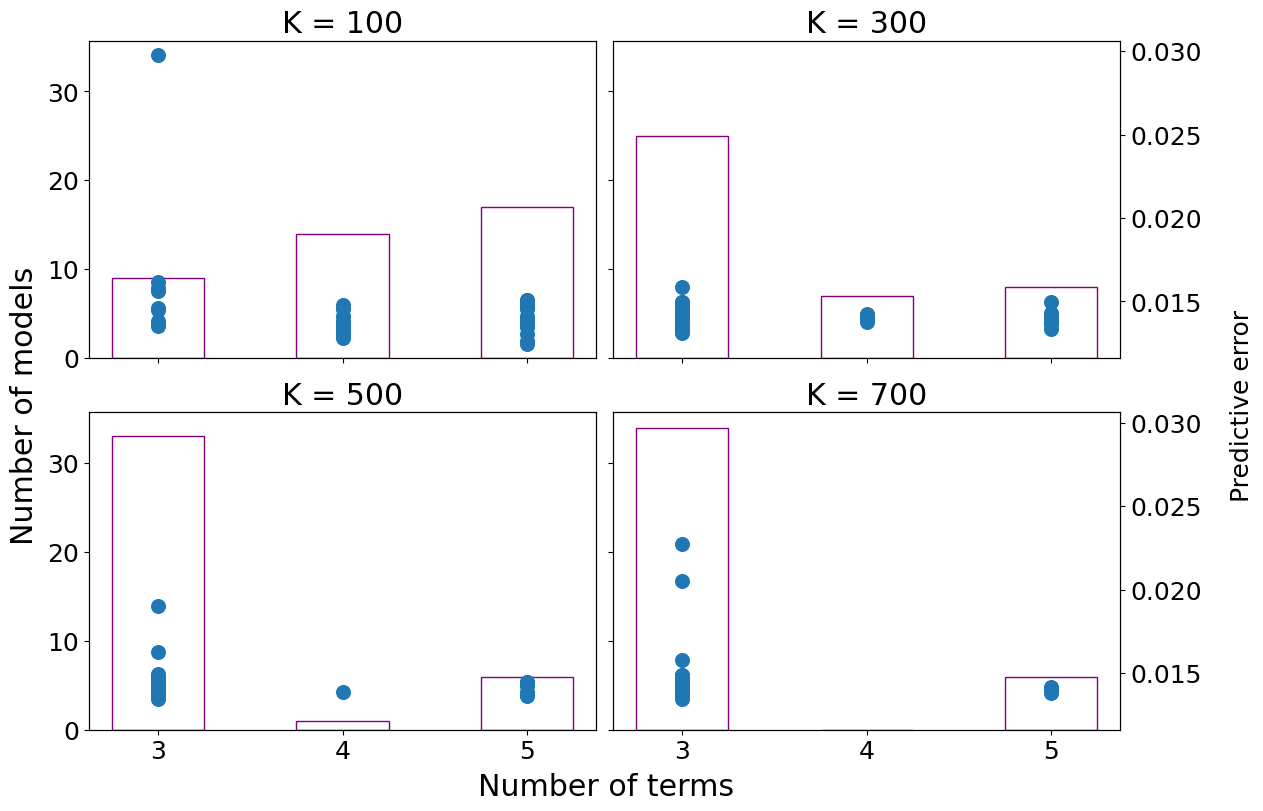

In [ ]:
plot_model_results(all_metrics, True, True, False)